# Load Image

In [1]:
import torch
import torchvision.transforms.v2 as T

from torchvision.datasets import ImageFolder

transforms = T.Compose([
    T.ToImage(),
    T.Resize((224, 224)),
    T.ToDtype(torch.float32, scale = True),
    T.Normalize(mean = (0.485, 0.456, 0.406), std = (0.229, 0.224, 0.225)),
])

dataset = ImageFolder(root = "./dataset/train/", transform = transforms)

In [2]:
from torch.utils.data import random_split

training_set, validation_set = random_split(dataset, [0.7, 0.3])

In [3]:
from torch.utils.data import DataLoader

train_loader = DataLoader(training_set, batch_size = 32, shuffle = True)
valid_loader = DataLoader(validation_set, batch_size = 32, shuffle = True)

# Construct model

In [4]:
from torchvision.models import resnet50, ResNet50_Weights

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Use {device} to train...\n")
    
model = resnet50(weights = ResNet50_Weights.IMAGENET1K_V2).to(device)
for parameter in model.parameters():
    parameter.require_grad = False
model.fc = torch.nn.Linear(2048, len(dataset.classes)).to(device)

print(model)

Use mps to train...

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_siz

# Train model & draw confusion matrix

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def draw_confusion_matrix(count, epoch):
    confusion_matrix = pd.DataFrame(count, index = dataset.classes, columns = dataset.classes)
    ax = sns.heatmap(confusion_matrix, cmap = "Blues", fmt = ".5g", annot = True)
    ax.tick_params(axis = "x")
    ax.tick_params(axis = "y")
    plt.title(f"Confusion Matrix of Epoch {epoch}")
    plt.savefig(f"one-fold validation/confusion matrix_epoch {epoch}.png", bbox_inches = "tight")
    plt.title("")
    plt.show()

In [6]:
import torch.nn.functional as F

from tqdm.notebook import tqdm

def train(model, device, train_loader, valid_loader, optimizer, num_epochs, n_classes):
    train_loss_record, val_loss_record = [], []
    for epoch in range(num_epochs):
        print("-" * 100)
        model.train()
        train_loss = train_corrects = 0

        # training
        with tqdm(train_loader) as tepoch:
            for inputs, targets in tepoch:
                # transfer data to gpu
                inputs = inputs.to(device)
                targets = targets.to(device)
        
                # forward
                outputs = model(inputs)
                loss = F.cross_entropy(outputs, targets)
        
                # backward
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
    
                _, preds = torch.max(outputs, 1)
                train_loss += loss.item() * inputs.size(0)
                train_corrects += torch.sum(preds == targets.data)

                tepoch.set_description(f"Epoch {epoch + 1}")
                tepoch.set_postfix(loss = loss.item())
            
        epoch_loss = train_loss / len(train_loader.dataset)
        epoch_acc = train_corrects / len(train_loader.dataset)
        train_loss_record.append(epoch_loss)
        print(f"Train - loss: {epoch_loss: .4f}, accuracy: {epoch_acc: .4f}")

        # validation
        valid_loss = valid_corrects = 0
        count = [[0] * n_classes for _ in range(n_classes)]
        model.eval()
        with torch.no_grad():
            for inputs, targets in valid_loader:
                # tranfer data to gpu
                inputs = inputs.to(device)
                targets = targets.to(device)

                # forward
                outputs = model(inputs)
                loss = F.cross_entropy(outputs, targets)

                # evaluation
                _, preds = torch.max(outputs, 1)
                for i in range(len(preds)):
                    count[preds[i].item()][targets[i].item()] += 1
                valid_loss += loss.item() * inputs.size(0)
                valid_corrects += torch.sum(preds == targets.data)

        epoch_loss = valid_loss / len(valid_loader.dataset)
        epoch_acc = valid_corrects / len(valid_loader.dataset)
        val_loss_record.append(epoch_loss)
        print(f"Validation - loss: {epoch_loss: .4f}, accuracy: {epoch_acc: .4f}")
        draw_confusion_matrix(count, epoch + 1)
        
        print("-" * 100)

    return train_loss_record, val_loss_record

----------------------------------------------------------------------------------------------------


  0%|          | 0/104 [00:00<?, ?it/s]

Train - loss:  1.8342, accuracy:  0.4559
Validation - loss:  1.4363, accuracy:  0.6512


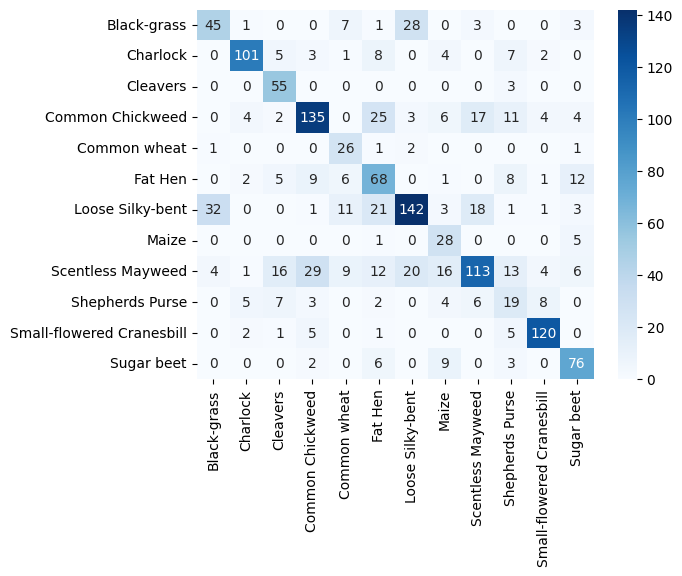

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


  0%|          | 0/104 [00:00<?, ?it/s]

Train - loss:  1.2143, accuracy:  0.6980
Validation - loss:  1.0893, accuracy:  0.7081


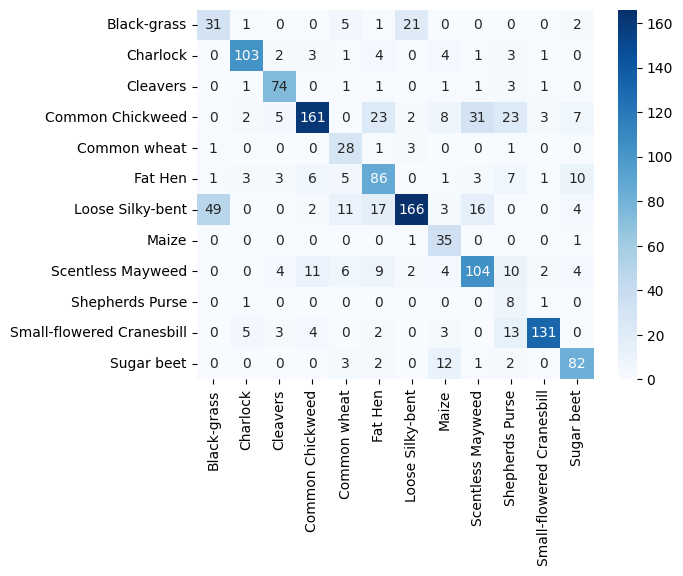

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


  0%|          | 0/104 [00:00<?, ?it/s]

Train - loss:  0.9474, accuracy:  0.7723
Validation - loss:  0.9575, accuracy:  0.7418


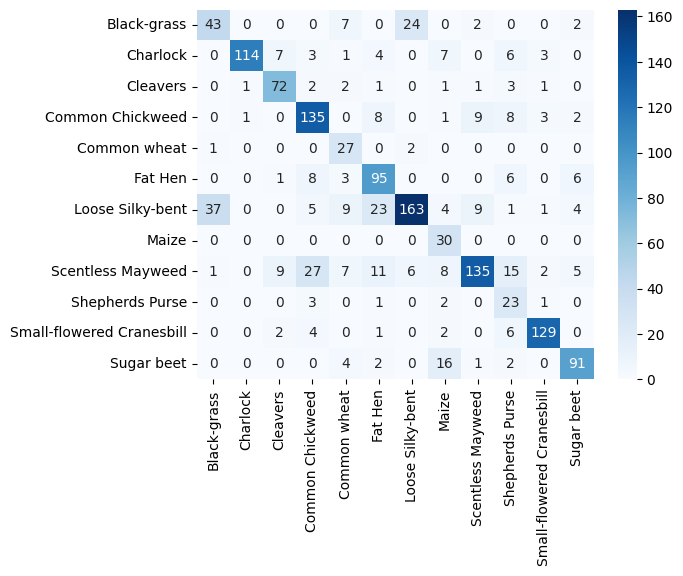

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


  0%|          | 0/104 [00:00<?, ?it/s]

Train - loss:  0.8021, accuracy:  0.8024
Validation - loss:  0.8206, accuracy:  0.7593


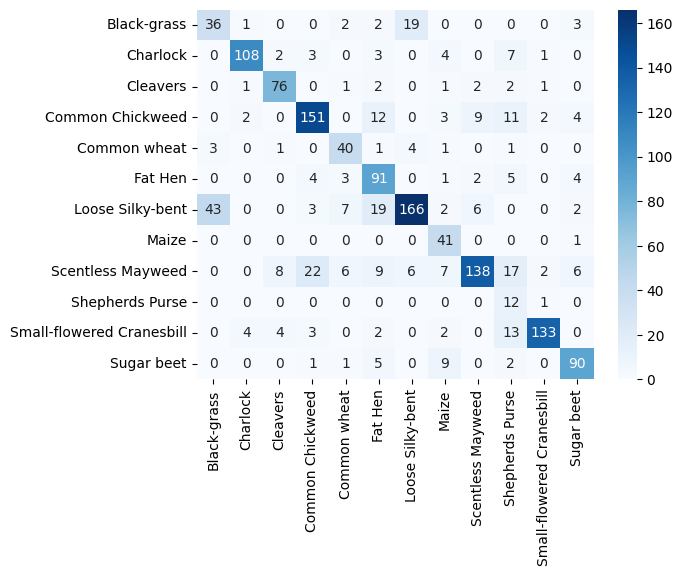

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


  0%|          | 0/104 [00:00<?, ?it/s]

Train - loss:  0.7047, accuracy:  0.8400
Validation - loss:  0.7627, accuracy:  0.7796


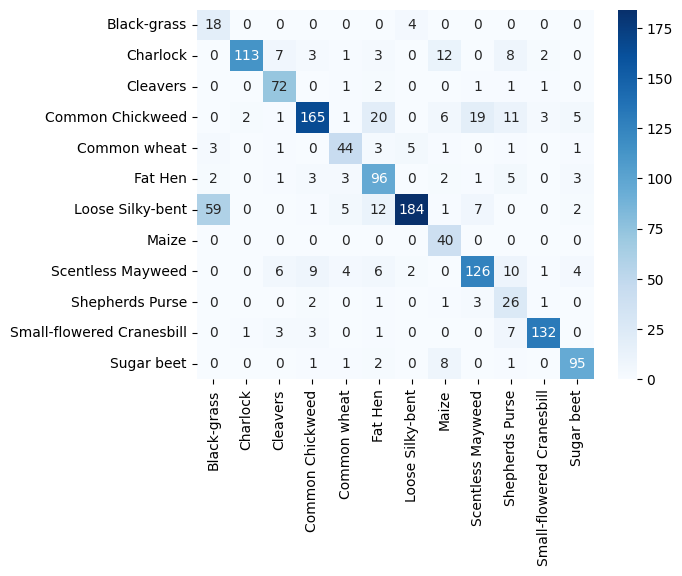

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


  0%|          | 0/104 [00:00<?, ?it/s]

Train - loss:  0.6241, accuracy:  0.8460
Validation - loss:  0.7024, accuracy:  0.8063


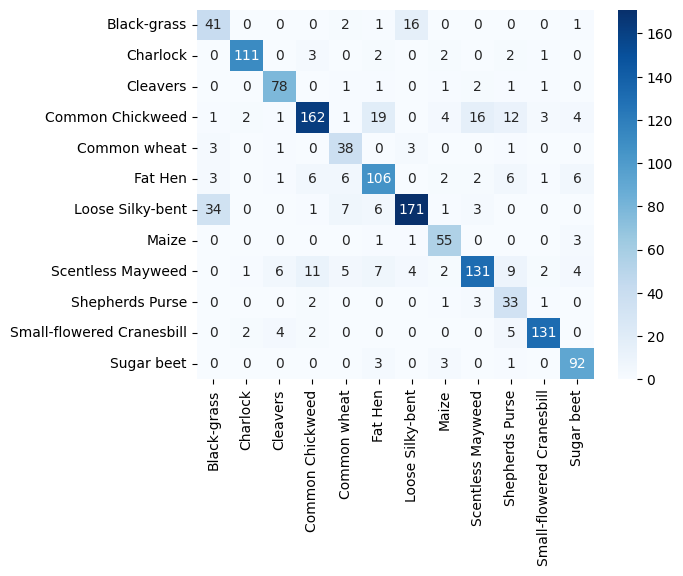

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


  0%|          | 0/104 [00:00<?, ?it/s]

Train - loss:  0.5754, accuracy:  0.8598
Validation - loss:  0.6494, accuracy:  0.8260


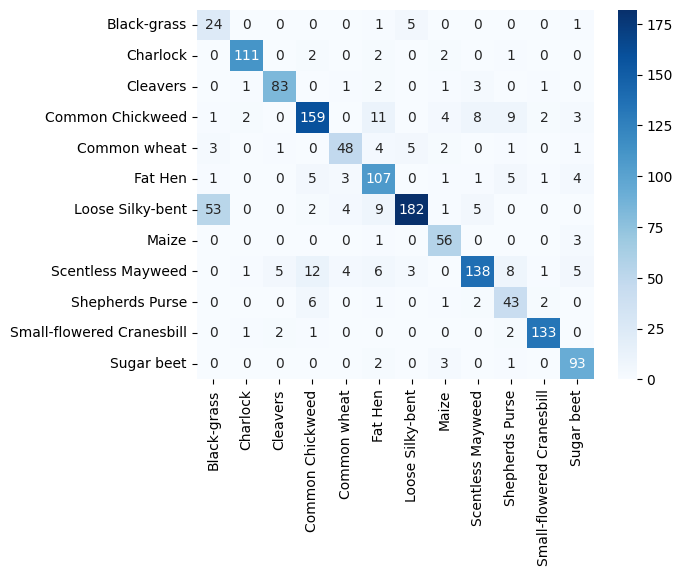

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


  0%|          | 0/104 [00:00<?, ?it/s]

Train - loss:  0.5217, accuracy:  0.8737
Validation - loss:  0.6208, accuracy:  0.8330


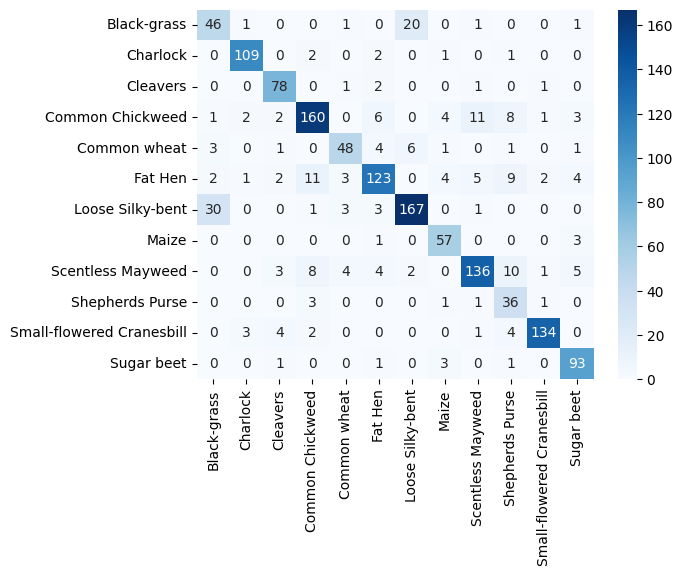

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


  0%|          | 0/104 [00:00<?, ?it/s]

Train - loss:  0.4815, accuracy:  0.8869
Validation - loss:  0.5948, accuracy:  0.8267


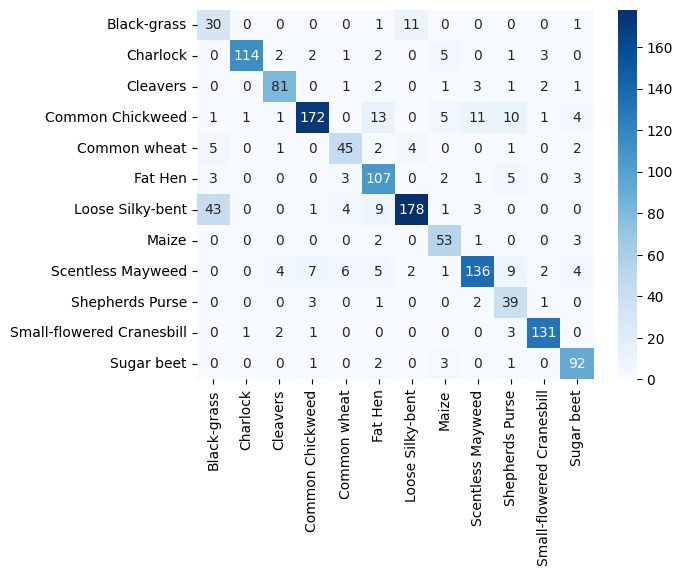

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


  0%|          | 0/104 [00:00<?, ?it/s]

Train - loss:  0.4359, accuracy:  0.9008
Validation - loss:  0.5997, accuracy:  0.8274


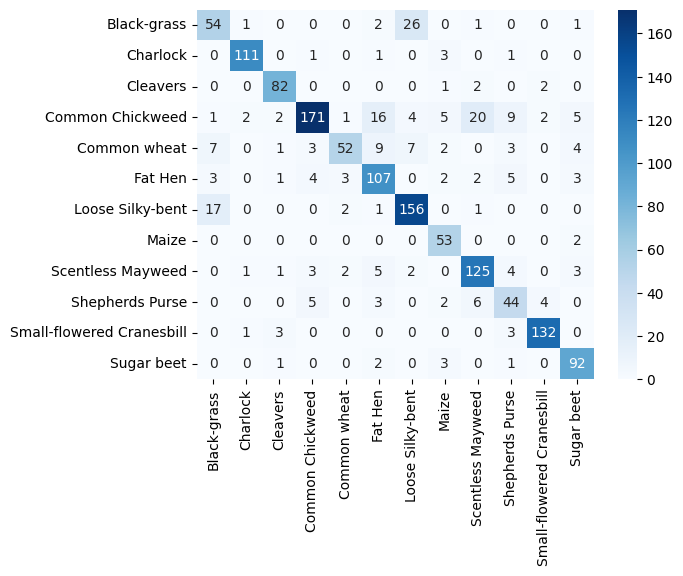

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


  0%|          | 0/104 [00:00<?, ?it/s]

Train - loss:  0.4116, accuracy:  0.9065
Validation - loss:  0.5785, accuracy:  0.8253


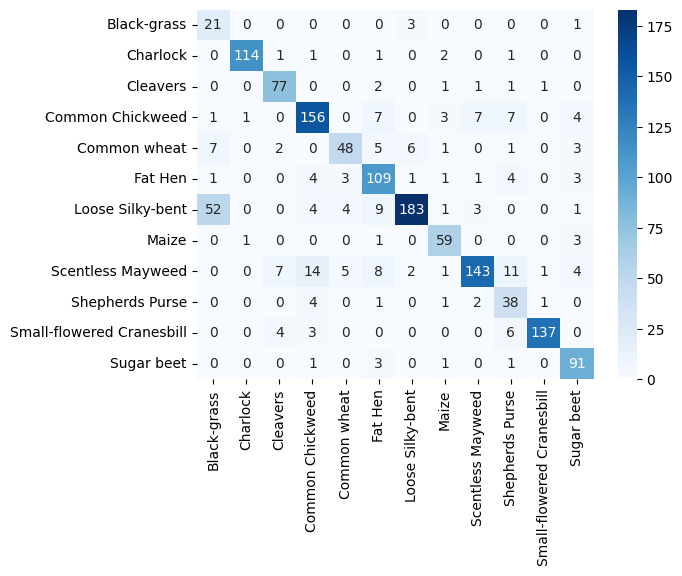

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


  0%|          | 0/104 [00:00<?, ?it/s]

Train - loss:  0.3878, accuracy:  0.9074
Validation - loss:  0.5484, accuracy:  0.8456


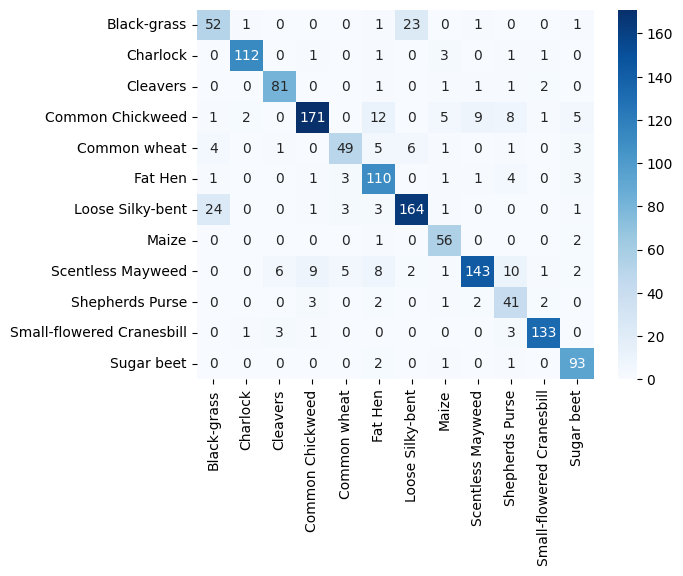

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


  0%|          | 0/104 [00:00<?, ?it/s]

Train - loss:  0.3613, accuracy:  0.9182
Validation - loss:  0.5563, accuracy:  0.8288


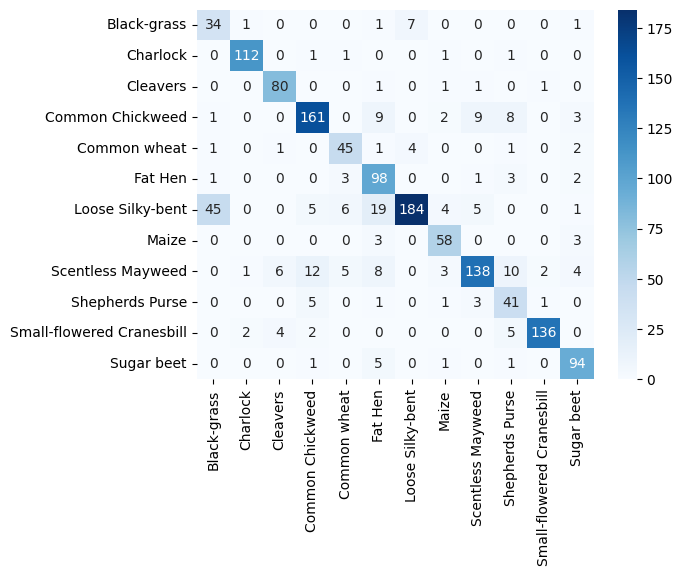

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


  0%|          | 0/104 [00:00<?, ?it/s]

Train - loss:  0.3484, accuracy:  0.9200
Validation - loss:  0.5369, accuracy:  0.8463


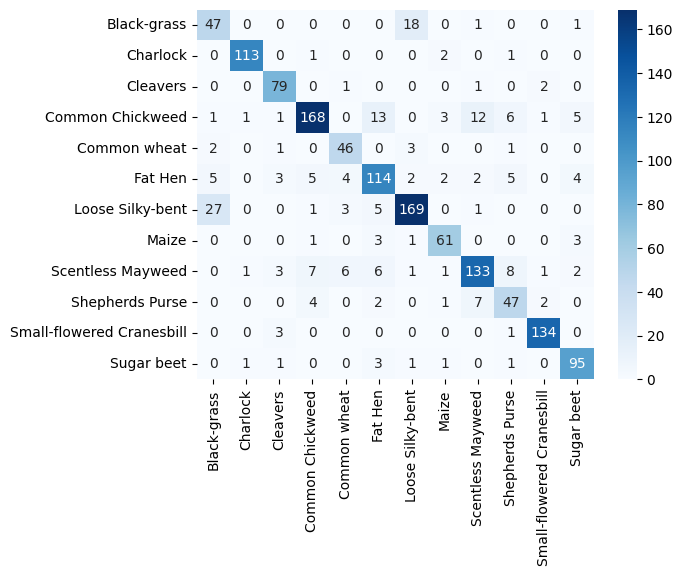

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


  0%|          | 0/104 [00:00<?, ?it/s]

Train - loss:  0.3452, accuracy:  0.9263
Validation - loss:  0.5348, accuracy:  0.8358


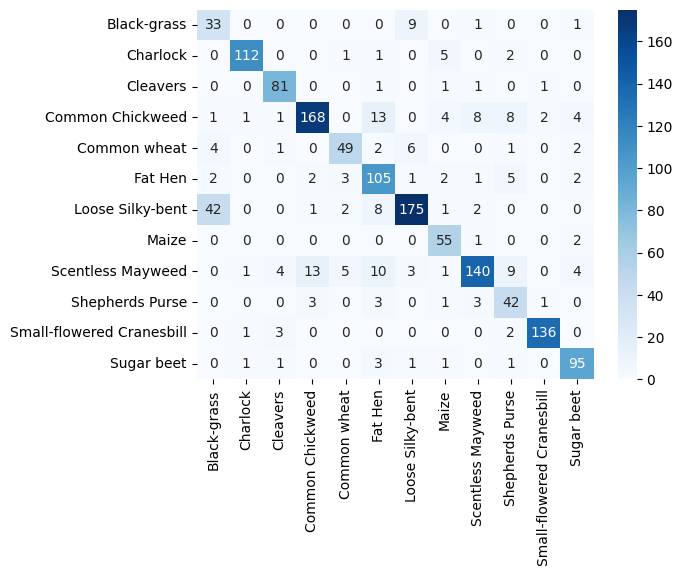

----------------------------------------------------------------------------------------------------


In [7]:
from torch.optim import Adam

optimizer = Adam(model.fc.parameters(), lr = 0.001)
num_epoch = 15
train_loss, val_loss = train(model, device, train_loader, valid_loader, optimizer, num_epoch, len(dataset.classes))

# Draw training / validation loss curve

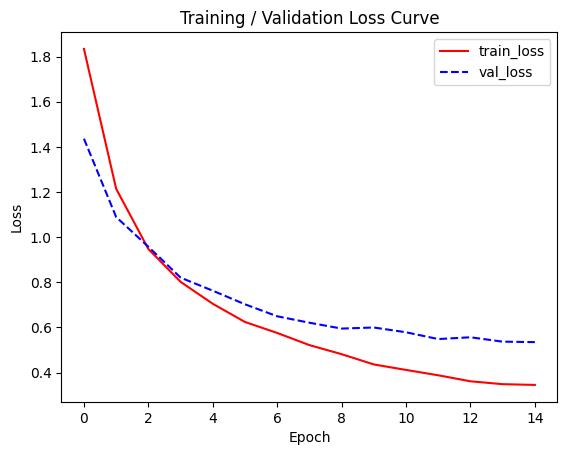

In [8]:
import matplotlib.pyplot as plt

x = [i for i in range(num_epoch)]

plt.plot(x, train_loss, linestyle = "-", color = "red", label = "train_loss")
plt.plot(x, val_loss, linestyle = "--", color = "blue", label = "val_loss")
plt.title("Training / Validation Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig("one-fold validation/loss_curve.png")
plt.show()

# Do prediction & write submission file

In [9]:
import os

from torch.utils.data import Dataset
from torchvision.io import read_image

class TestImageDataset(Dataset):
    def __init__(self, img_path, transform = None):
        self.img_path = img_path
        self.transform = transform

    def __len__(self):
        return len(self.img_path)

    def __getitem__(self, idx):
        image_name = self.img_path[idx].split("/")[-1]
        image = read_image(self.img_path[idx])
        if self.transform:
            image = self.transform(image)

        return image_name, image

In [10]:
@torch.no_grad()
def test(model, device, test_loader, mapping_dict):
    model.eval()
    predictions = []
    with tqdm(test_loader) as loader:
        loader.set_description("Testing")
        for image_name, inputs in loader:
            inputs = inputs.to(device, non_blocking = True)
    
            # forward
            outputs = model(inputs)
    
            # evaluation
            pred = outputs.argmax(dim = 1, keepdim = True)[0][0]
            pred = mapping_dict[pred.item()]
            predictions.append((image_name[0], pred))

    return predictions

In [11]:
import glob

testing_set = TestImageDataset(glob.glob("dataset/test/*.png"), transforms)
test_loader = DataLoader(testing_set)
mapping_dict = {i: label for i, label in enumerate(dataset.classes)}
prediction = test(model, device, test_loader, mapping_dict)

  0%|          | 0/794 [00:00<?, ?it/s]

In [12]:
with open("prediction/submission (one-fold validation).csv", "w") as file:
    file.write("file,species\n")
    for image_name, pred in prediction:
        file.write(f"{image_name},{pred}\n")

# Save weights of model

In [13]:
torch.save(model.state_dict(), "model_weights/model_weights (one-fold validation).pth")

# Load weights of model

In [14]:
if torch.cuda.is_available():
    weigths = torch.load("model_weights/model_weights (one-fold validation).pth", map_location = "cuda", weights_only = True)
elif torch.backends.mps.is_available():
    weights = torch.load("model_weights/model_weights (one-fold validation).pth", map_location = "mps", weights_only = True)
else:
    weights = torch.load("model_weights/model_weights (one-fold validation).pth", map_location = "cpu", weights_only = True)
    
model.load_state_dict(weights)

<All keys matched successfully>